In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
from sqlalchemy import create_engine, inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
scolumns = inspector.get_columns('station')
for c in scolumns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
one_year_ago = dt.date.today() - dt.timedelta(days=365)
print('The Day of 1 year ago for today is: ',one_year_ago)

# Perform a query to retrieve the data and precipitation scores
#Since there is no data for last 12 months, I used the 12 months before one_year_ago instead
another_1_year_ago = one_year_ago - dt.timedelta(days=365)
rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= another_1_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain).rename(columns={"date": "Date", "prcp": "Precipitation"}).set_index("Date")

# Sort the dataframe by date
rain_df = rain_df.sort_values(by="Date", ascending=True)
rain_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
rain_df.plot()
plt.show()

The Day of 1 year ago for today is:  2017-08-28


<IPython.core.display.Javascript object>

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,Precipitation
count,1991.000000
mean,0.173420
std,0.454679
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.
act_stations = session.query(Measurement.station,func.count(Measurement.station)).\
               group_by(Measurement.station).\
               order_by(func.count(Measurement.station).desc()).all()
act_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
id_most_act_station = act_stations[0][0]
data_most_act_temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == id_most_act_station).\
                filter(Measurement.date > another_1_year_ago).all()
data_most_act_temp

[(59.0, 83.0, 73.04046242774567)]

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_station = session.query(Measurement.station,func.max(Measurement.tobs)).\
                  filter(Measurement.date > another_1_year_ago).all()
one_year_temp = session.query(Measurement.date,Measurement.tobs).\
                filter(Measurement.station == highest_station[0][0]).\
                order_by(Measurement.date).statement
temp_df = pd.read_sql_query(one_year_temp,session.bind).rename(columns={"date": "Date", "tobs": "Temperatures"}).set_index("Date")
temp_df.plot.hist()
plt.show()

<IPython.core.display.Javascript object>

In [18]:
from datetime import datetime

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    start_date = datetime.strptime(start_date,'%Y-%m-%d')
    end_date = datetime.strptime(end_date,'%Y-%m-%d')
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.4375, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
ctemp_data = calc_temps('2017-02-28','2017-03-05')
ctemp_data

[(64.0, 71.96551724137932, 78.0)]

<IPython.core.display.Javascript object>


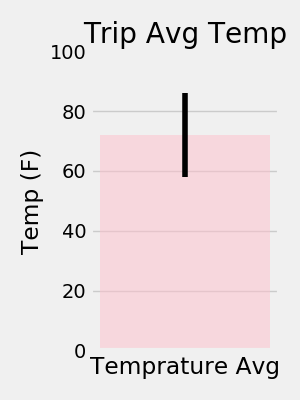

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = ctemp_data[0][0]
tavg = ctemp_data[0][1]
tmax = ctemp_data[0][2]

plt.figure(figsize=(3,4))
plt.bar(1,height=tavg, yerr=(tmax-tmin), width=0.0001, alpha=0.5, color = "pink")
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylim(0,100)
plt.xlabel ("Temprature Avg")
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig("Trip_Avg_Temp.png")
plt.show()

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
              group_by(Measurement.station).\
              filter(Measurement.date <= '2017-03-05').\
              filter(Measurement.date >= '2017-02-28').\
              order_by(func.sum(Measurement.prcp).desc()).all()

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
start_date = '2018-01-01'
end_date = '2018-01-05'
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
trip_dates = ['2018-01-01','2018-01-02','2018-01-03','2018-01-04','2018-01-05']
trip_dates_without_year = []
for i in trip_dates:
    trip_dates_without_year.append(i.replace('2018-',''))
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in trip_dates_without_year:
    normals.append(daily_normals(date)[0])
print(normals)

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date_df = pd.DataFrame(normals, columns=('tmin','tavg','tmax'))
date_df['date'] = trip_dates
date_df.set_index('date')

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
date_df.plot.area(stacked=False)